In [18]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

la simulation chargée est: dahu_619
depuis: dahu
shape of psi : (145, 2048, 2048)
{'NX': 2048.0, 'NY': 2048.0, 'nl': 1.0, 'Lx': 502.65482457, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.00390625, 'tend': 1576800000000.0, 'dt_out': 0.05}


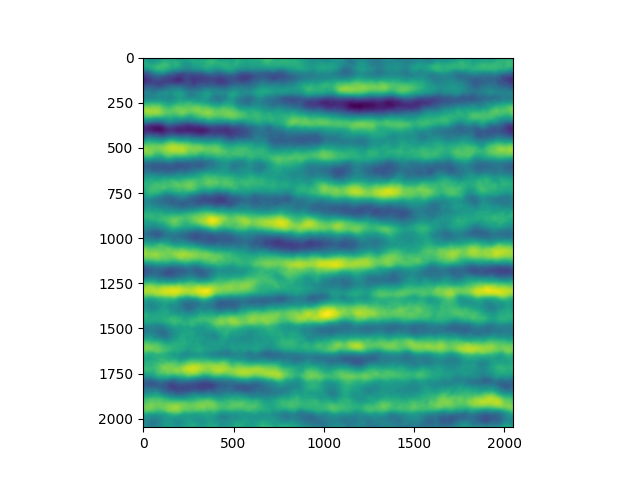

In [19]:


# Number of simulation
n = 619

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [20]:
#################################################################Aide de Chat GPT########################################################################""


def fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    imag_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    
    Kx, Ky = np.meshgrid(kx, ky)

    for i, time_sel in enumerate(time_tab):
        psi_data = psi[time_sel, :, :]
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        
        real_part_tab[i, :, :] = np.real(fft_result)
        imag_part_tab[i, :, :] = np.imag(fft_result)

    return real_part_tab, imag_part_tab, Kx, Ky

def fft2d_RI(psi, Lx, nx, ny,time_sel=1):
    
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
    
    psi_data = psi[time_sel, :, :]

    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi_data) / (nx * ny)  
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

    print(np.shape(fft_shifted))
    return fft_shifted, Kx, Ky



def pulsation_vect_optimized(real_part_tab, imag_part_tab, t,time_tab):
    dt = t[time_tab[1]] - t[time_tab[0]]
    count = real_part_tab.shape[0] - 1

    pulsation_sum = np.zeros_like(real_part_tab[0], dtype=complex)
    pulsation_var = np.zeros_like(real_part_tab[0], dtype=complex)
    for t in range(count):
        real_t, imag_t = real_part_tab[t], imag_part_tab[t]
        real_t1, imag_t1 = real_part_tab[t + 1], imag_part_tab[t + 1]
        
        amp_t = np.sqrt(real_t**2 + imag_t**2)
        psi_t = (real_t + 1j * imag_t) / np.max(amp_t)
        
        amp_t1 = np.sqrt(real_t1**2 + imag_t1**2)
        psi_t1 = (real_t1 + 1j * imag_t1) / np.max(amp_t1)

        psi_conj_interp = (np.conjugate(psi_t1) + np.conjugate(psi_t)) / 2
        psi_norm_interp = (amp_t + amp_t1) / 2

        dreal_dt = (real_t1 - real_t) / dt
        dimag_dt = (imag_t1 - imag_t) / dt
        pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

        psi_squared_t = real_t**2 + imag_t**2
        psi_squared_t1 = real_t1**2 + imag_t1**2
        sterm = (psi_squared_t1 - psi_squared_t) / dt

        pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)
        pulsation_sum += np.abs(pulsation_t)
        pulsation_var += pulsation_t**2

    pulsation_observed_mean = pulsation_sum / count
    pulsation_var = pulsation_var / count 
    return pulsation_observed_mean, pulsation_var



(144, 2048, 2048)


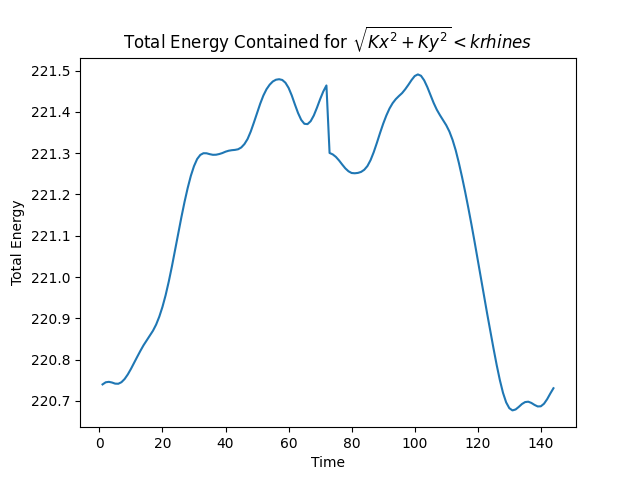

In [28]:
#Computing the energy contain in the rossby waves
epsilon =sigma_f**2
r= hEkb
time_sel = np.arange(1, len(t), 1)
fft,Kx,Ky = fft2d_RI(psi,Lx,nx,ny,time_sel)

k_rhines=beta**0.5/(epsilon/r)**(1/4)
energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
# Compute the magnitude of the wave numbers
k_mag = np.sqrt(Kx**2 + Ky**2)

mask = np.zeros_like(k_mag)
mask[k_mag<k_rhines]=1
# Filter out the energies for k < krhines
energy_filtered = energy_mat*mask

# Sum the total energy for the filtered values
total_energy = np.sum(energy_filtered,axis=(1,2))
 
# Plot the total energy
plt.figure()
plt.plot(time_sel,total_energy)
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.title('Total Energy Contained for $\\sqrt{Kx^2 + Ky^2} < krhines$')
plt.show()


la simulation chargée est: dahu_922
depuis: dahu
shape of psi : (1200, 2049, 2049)
{'NX': 2048.0, 'NY': 2048.0, 'nl': 1.0, 'Lx': 314.15926535897927, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.0016, 'tend': 1576800000000.0, 'dt_out': 0.02}


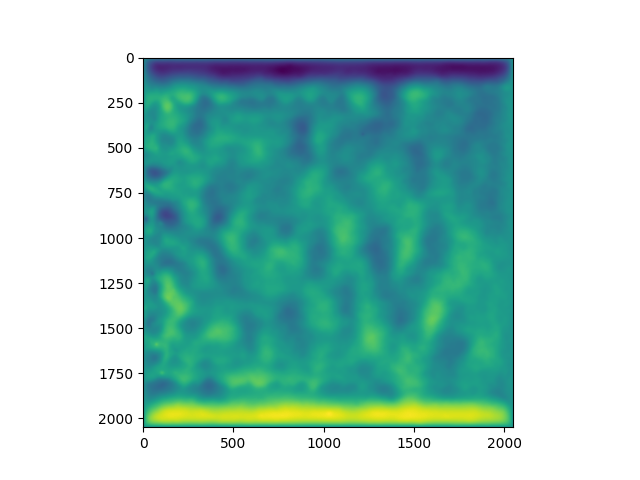

In [29]:


# Number of simulation
n = 922

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [30]:
q_prime = q - np.mean(q, axis=0)

In [31]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [32]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [34]:

def pulsation(psi_mn,t,t_sel):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[t_sel[1]] - t[t_sel[0]]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

In [35]:
#Batch optimisation 
time_sel = np.arange(0, len(t), 1, dtype=int)
pi = np.pi

def finding_parameters(m_sel, n_sel, time_sel,q, t):
    """
    Process a single (m, n) mode and return data for plotting if conditions are met.
    """
    # Finding the projection of the field on the mode
    psi_mn = project_basin(q_prime[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
    pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    
    # Conditions to discriminate the modes with wave-like behavior
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) 
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) 
    condition3 = rel_err 

    return condition1, condition2, condition3

m_list = np.arange(0, 20, 1) 
n_list = np.arange(0, 20, 1) 

condition1_tab = np.zeros((len(n_list), len(m_list)))
condition2_tab = np.zeros((len(n_list), len(m_list)))
condition3_tab = np.zeros((len(n_list), len(m_list)))   

# Batch processing
batch_size = 5
m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

for batch_idx, m_batch in enumerate(m_batches):
    print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
    results = Parallel(n_jobs=-1)(delayed(finding_parameters)(m, n, time_sel, q, t) for m in m_batch for n in n_list)
    
    for idx, (m, n) in enumerate([(m, n) for m in m_batch for n in n_list]):
        m_idx = np.where(m_list == m)[0][0]
        n_idx = np.where(n_list == n)[0][0]
        condition1_tab[n_idx, m_idx], condition2_tab[n_idx, m_idx], condition3_tab[n_idx, m_idx] = results[idx]


Processing batch 1/4


/tmp/ipykernel_56676/786397264.py:15: RuntimeWarning: divide by zero encountered in scalar divide


In [ ]:



def energy_spectrum(psi_mn, m, n, L):
    E_mn_list=np.abs(psi_mn)**2/L
    E_mn = np.mean(E_mn_list, axis = 0)
    return E_mn, np.sqrt(m**2 + n**2) 

E_list_mn = []
sqrt_list = []
time_sel = np.arange(0, len(t), 1, dtype=int)
E_mn_2D = np.zeros((19, 19))
#Looping over all modes to compute the 1D energy spectrum
for m in range(1,20):
    for n in range(1,20):
       psi_mn = project_basin(q_prime[time_sel, :, :], m, n, Lx, norm=0)
       E_mn, sqrt_mn = energy_spectrum(psi_mn, m, n, Lx)
       E_mn_2D[m-1, n-1] = E_mn
       E_list_mn.append(E_mn)
       sqrt_list.append(sqrt_mn)
    print(m)